In [1]:
# !pip install pillow
# !pip install opencv-python
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow==2.10
# !pip install scikit-learn

**Ini merupakan project computer vision untuk deteksi kantuk pengemudi kendaraan yang menggunakan algoritma Convolutional Neural Network (CNN) menggunakan library tensorflow**

Dataset: https://www.kaggle.com/datasets/hazemfahmy/openned-closed-eyes/data

by Hazem Fahmy

**Tentang Dataset**

Selamat datang di Dataset Deteksi Kantuk UnityEyes! Dataset komprehensif ini dirancang untuk membantu para peneliti dan pengembang dalam tugas penting deteksi kantuk, yang secara khusus berfokus pada identifikasi pengemudi yang mengantuk berdasarkan perilaku mata. Dataset ini dikumpulkan menggunakan UnityEyes, sebuah simulator sintetis mata yang canggih, untuk memastikan data berkualitas tinggi. Data tersebut diberi label menggunakan ambang batas keterbukaan = 20 (referensi: https://github.com/SNTSVV/HUDD-Toolset)

Dataset Deteksi Mengantuk terdiri dari beragam koleksi rekaman gerakan mata dari subjek dengan demografi yang berbeda-beda, yang diambil dalam skenario mengemudi yang terkendali. Data tersebut mencakup urutan gambar mata, yang diberi label secara cermat untuk menunjukkan apakah mata terbuka atau tertutup, yang berfungsi sebagai kebenaran dasar untuk mendeteksi pengemudi yang mengantuk.

## **Import Library**

In [2]:
import os
import random
import numpy as np
import pandas as pd
from PIL import  Image
import string

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(tf.__version__)

2.12.0


In [3]:
import warnings
# Abaikan semua warning
warnings.filterwarnings('ignore')

Beberapa fungsi library yang digunakan:
- **os**: Untuk mengoperasikan sistem operasi.
- **cv2**: OpenCV untuk tugas-tugas computer vision.
- **PIL**: Library pencitraan Python untuk tugas-tugas pemrosesan gambar.
- **numpy**: Untuk komputasi numerik dan matriks.
- **matplotlib.pyplot**: Untuk visualisasi plot.
- **seaborn**: Untuk visualisasi plot.
- **sklearn**: Untuk preprocessing data dan evaluasi akurasi
- **tensorflow**: Untuk membangun dan melatih model pembelajaran mesin.

## **Load Data from Directory**

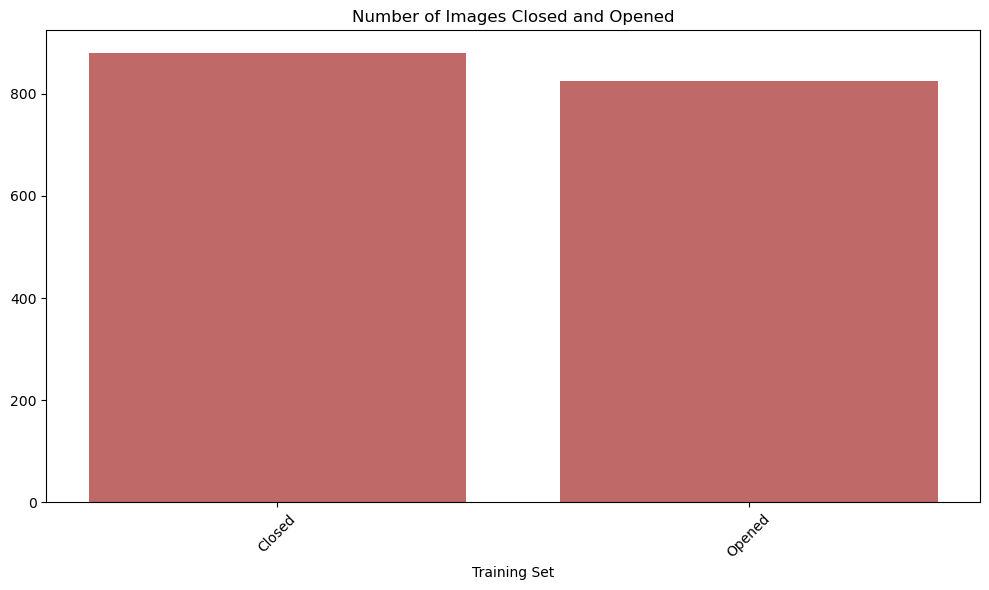

In [4]:
# directory yang mengandung Image
root_dir = './drownisess/TrainingSet/TrainingSet'

# Iterasi melalui setiap folder di direktori root
folder_image_count = {}

for data in os.listdir(root_dir):
    path_folder = os.path.join(root_dir, data)
    if os.path.isdir(path_folder):
        # Menghitung jumlah file gambar di dalam folder
        num_images = len([name for name in os.listdir(path_folder) if os.path.isfile(os.path.join(path_folder, name)) and name.lower().endswith(('.png', '.jpg', '.jpeg'))])
        folder_image_count[data] = num_images

# Extract nama folder dan jumlah gambar yang sesuai
folders = list(folder_image_count.keys())
img_counts = list(folder_image_count.values())

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(folders)), img_counts, color = 'brown', align='center', alpha=0.7)
plt.xticks(range(len(folders)), folders, rotation=45)
plt.xlabel('Training Set')
plt.title('Number of Images Closed and Opened')
plt.tight_layout()
plt.show()

Setelah melakukan exttact data dari direktori path yang telah ditentukan, di dapatkan data Training Set yang terdiri dari 2 data mata Terbuka dengan 824 gambar dan mata Mengantuk dengan 880 gambar. Pastikan folder dataset berada ditempat yang sama seperti folder .py atau jupyter anda.

Contoh direktori yang benar:

**Project**

----- **drownisess**
 
----- **drownisess-detection.ipynb**

## **Preprocessing Data**

Setelah dilakukan extract data, akan dilakukan transform data. Dataset akan dikelompokan berdasarkan label masing-masing lalu dilakukan resize image untuk mengcompress gambar mnejadi ukuran 150x150 dengan 3 channel warna karena merupakan gambar RGB.

In [5]:
categories = ['Opened', 'Closed'] # Folder yang akan dimuat
image_size = (150, 150) # Untuk setting ukuran gambar

# Inisialisasi list untuk menyimpan data dan label
X = []
Y = []

# Memuat gambar dan label dari setiap folder
for label, category in enumerate(categories):
    folder_path = os.path.join(root_dir, category)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize(image_size)  # Mengubah ukuran gambar
            img_array = np.array(img)     # Mengonversi gambar menjadi array numpy
            X.append(img_array)
            Y.append(label)

# Mengonversi list X dan Y menjadi array numpy
X = np.array(X)
Y = np.array(Y)

Label mata terbuka **“Opened”: 0** dan Label mata mengantuk **“Closed”: 1**

In [6]:
print(f'Total gambar: {len(X)}')
print(f'Total label: {len(Y)}')
print('kode label:', np.unique(Y))

Total gambar: 1704
Total label: 1704
kode label: [0 1]


In [7]:
X[0]

array([[[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       ...,

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]]], dtype=uint8)

Melakukan load data yang telah di extract dan di transform untuk melihat 5 sampel masing-masing setiap label

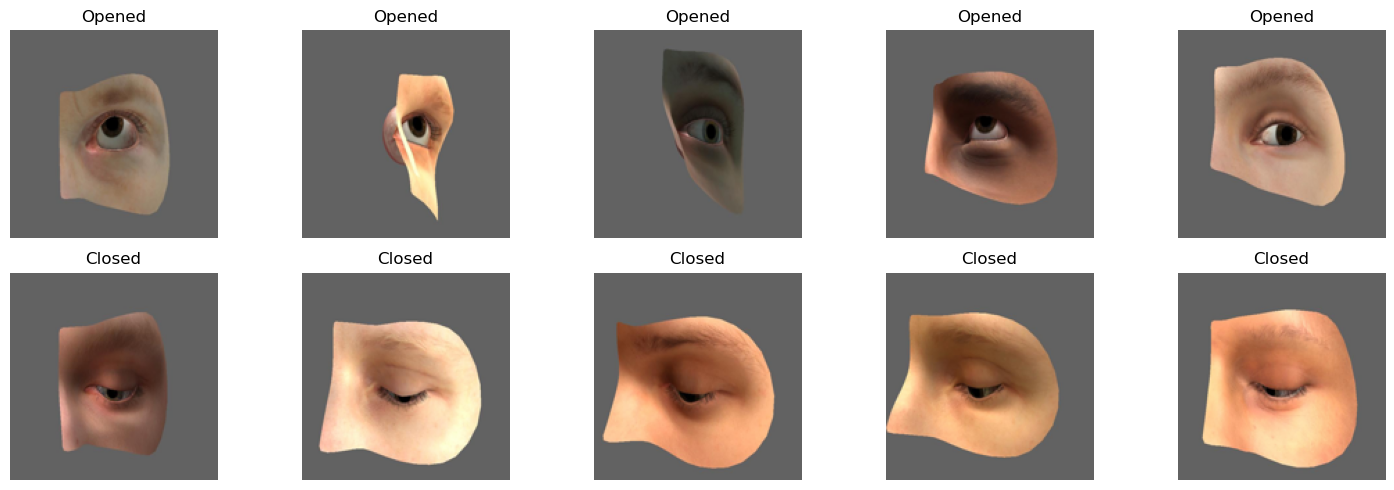

In [8]:
# Memisahkan gambar berdasarkan label
X_opened = X[Y == 0]
X_closed = X[Y == 1]

# Mengambil 5 sampel acak dari masing-masing kategori
opened_samples = np.random.choice(len(X_opened), 5, replace=False)
closed_samples = np.random.choice(len(X_closed), 5, replace=False)

X_samples = np.concatenate((X_opened[opened_samples], X_closed[closed_samples]))
Y_samples = np.concatenate((np.zeros(5), np.ones(5)))

# Menampilkan 10 sampel gambar
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_samples[i])
    plt.title('Opened' if Y_samples[i] == 0 else 'Closed')
    plt.axis('off')
plt.tight_layout()
plt.show()

Membagi data menjadi data training 90% dan data validation 10%

In [9]:
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.1, random_state=79)

In [10]:
print(x_train.shape)
print(y_train.shape)

(1533, 150, 150, 3)
(1533,)


terdapat 1533 gambar untuk data training

In [11]:
print(x_validation.shape)
print(y_validation.shape)

(171, 150, 150, 3)
(171,)


terdapat 171 gambar untuk data validation

In [12]:
# Mengonversi y_train dan y_validation menjadi kategorikal (one-hot encoded vectors.)
y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)

## **Model CNN 1 [Regularization Yes - Batch Size 32]**

Model pertama adalah model CNN tanpa transfer learning dengan 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN dengan memakai regularization dan batch size = 32

In [13]:
# Define jumlah kelas
num_classes = 2

# Input layer
inputs = Input(shape=(150, 150, 3))

# Layer 1
x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 4
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 5
x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten layer untuk convert the 3D feature maps menjadi 1D
x = Flatten()(x)

# Dense layer dengan 1024 neurons dan ReLU activation
x = Dense(1024, kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
x = Dense(num_classes, kernel_regularizer=regularizers.l2(0.01))(x)
outputs = Activation('softmax')(x)

# Membuat model_cnn_1
model_cnn_1 = Model(inputs=inputs, outputs=outputs)

# Melakukan compile dengan categorical crossentropy loss, Adam optimizer, & accuracy metrik
model_cnn_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Membuat checkpoint callback uuntuk menyimpan best model_cnn_1 based berdasarkan validation accuracy
checkpointCNN_1 = ModelCheckpoint('best_model_cnn_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_cnn_1
batch_size = 32 
historyCNN_1 = model_cnn_1.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        verbose=1, 
                        epochs=30, 
                        validation_data=(x_validation, y_validation), 
                        shuffle=False,
                        callbacks=[checkpointCNN_1, custom_early_stopping])

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 17.4760 - accuracy: 0.6667
Epoch 1: val_accuracy improved from -inf to 0.84795, saving model to best_model_cnn_1_CNN.h5
48/48 [==============================] - 32s 635ms/step - loss: 17.4760 - accuracy: 0.6667 - val_loss: 9.9863 - val_accuracy: 0.8480
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 8.5763 - accuracy: 0.9080
Epoch 2: val_accuracy improved from 0.84795 to 0.95906, saving model to best_model_cnn_1_CNN.h5
48/48 [==============================] - 27s 561ms/step - loss: 8.5763 - accuracy: 0.9080 - val_loss: 7.3453 - val_accuracy: 0.9591
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 6.5738 - accuracy: 0.9309
Epoch 3: val_accuracy improved from 0.95906 to 0.97076, saving model to best_model_cnn_1_CNN.h5
48/48 [==============================] - 27s 552ms/step - loss: 6.5738 - accuracy: 0.9309 - val_loss: 5.7797 - val_accuracy: 0.9708
Epoch 4/30
48/48 [=================

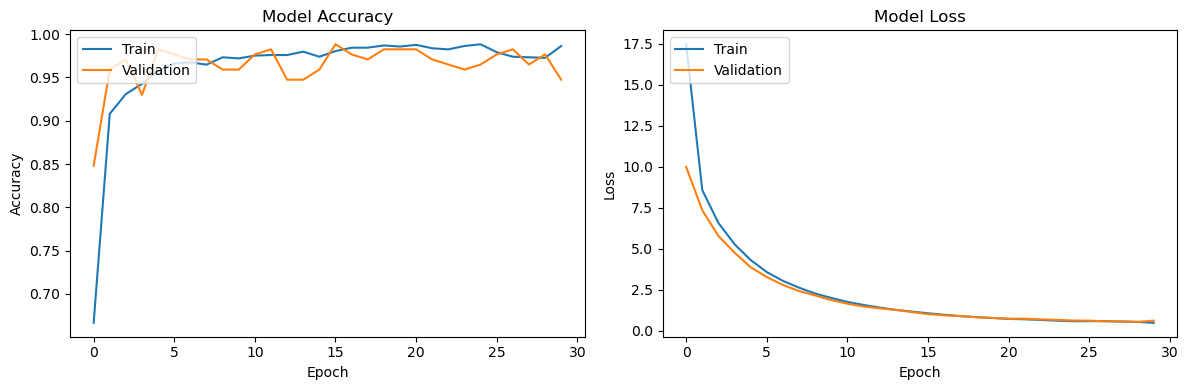

In [14]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyCNN_1.history['accuracy'])
ax1.plot(historyCNN_1.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyCNN_1.history['loss'])
ax2.plot(historyCNN_1.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
# Load model terbaik dari checkpoint
best_model_cnn_1 = tf.keras.models.load_model('best_model_cnn_1.h5')

# Evaluasi akurasi dan loss pada set validation
loss, accuracy = best_model_cnn_1.evaluate(x_validation, y_validation)
print(f'Validation Accuracy: {accuracy * 100:.3f}%')
print(f'Validation Loss: {loss:.4f}')

# Generate classification report
y_pred = best_model_cnn_1.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_best_cnn_1 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN 1:')
print(class_report_best_cnn_1)

6/6 [==============================] - 1s 94ms/step - loss: 1.0084 - accuracy: 0.9883
Validation Accuracy: 98.830%
Validation Loss: 1.0084
6/6 [==============================] - 1s 112ms/step
Classification Report Model CNN 1:
              precision    recall  f1-score   support

      Opened       1.00      0.98      0.99        87
      Closed       0.98      1.00      0.99        84

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [16]:
# Evaluasi akurasi dan loss pada set validation
validation_loss, validation_accuracy = model_cnn_1.evaluate(x_validation, y_validation, verbose=1)
print(f'validation accuracy: {validation_accuracy*100:.3f}%')
print(f'validation loss: {validation_loss:.4f}')

# Memprediksi label pada set validation
y_pred = model_cnn_1.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_cnn_1 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN 1:')
print(class_report_cnn_1)

6/6 [==============================] - 1s 83ms/step - loss: 0.6093 - accuracy: 0.9474
validation accuracy: 94.737%
validation loss: 0.6093
6/6 [==============================] - 1s 84ms/step
Classification Report Model CNN 1:
              precision    recall  f1-score   support

      Opened       0.92      0.98      0.95        87
      Closed       0.97      0.92      0.94        84

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



Validation Akurasi yang didapatkan model ini sebesar 95.9% dan F1-Score yang dihasilkan sebesar 96% untuk model CNN tanpa transfer learning, setekah itu melihat confusion matriks untuk melihat berapa data yang dapat ditebak dengan tepat dan tidak tepat

Confusion Matrix:
[[85  2]
 [ 0 84]]


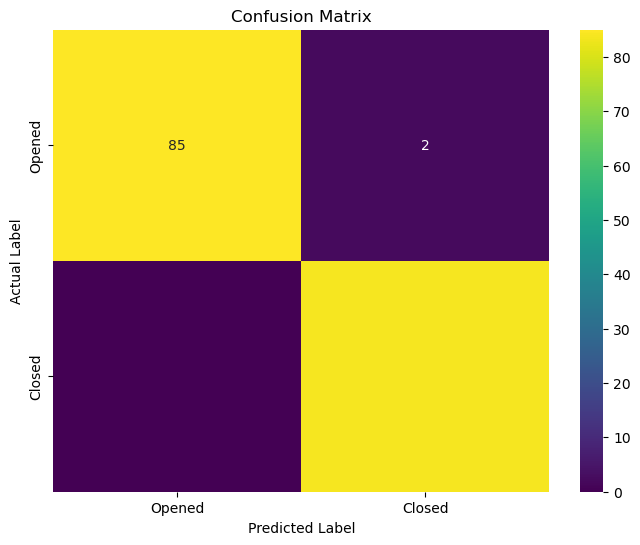

In [20]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model CNN 1**

melakukan predict data dengan gambar baru pada folder Test Set untuk melihat prediksi pada data yang belum pernah dikenali model

1/1 [==============================] - 0s 27ms/step


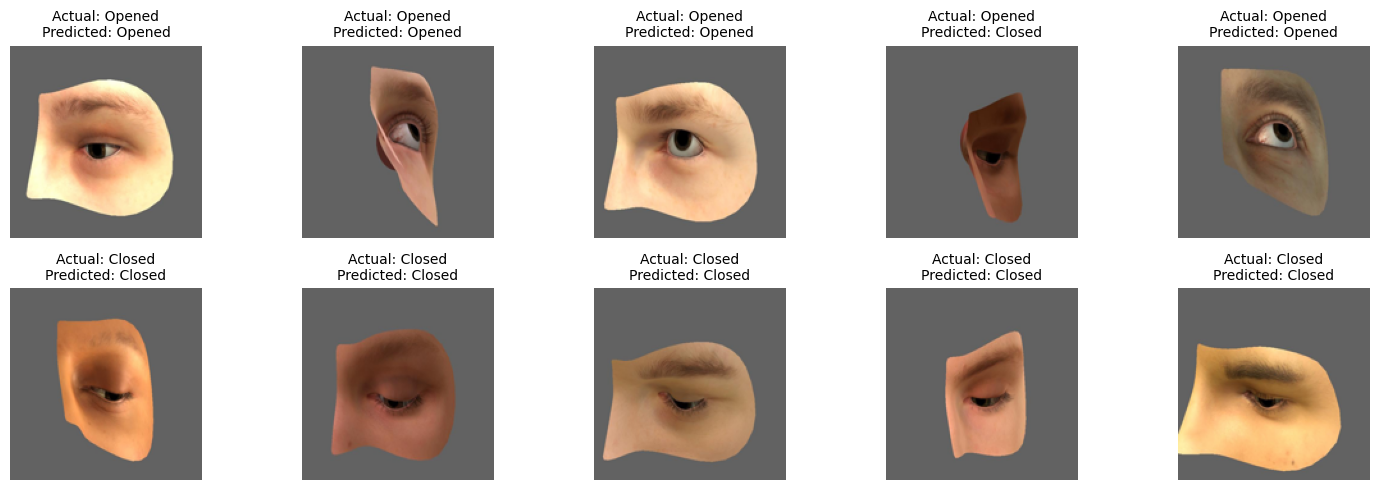

In [23]:
# Load model .h5
model_predict_1 = tf.keras.models.load_model('best_model_cnn_1.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

# Membuat list categories
categories = ['Opened', 'Closed']

# Inisialisasi lists untuk store images (X) dan label yang ada (Y)
X_samples = []
Y_samples = []

# preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array

for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    # Shuffle image untuk memastikan gambar dirandom
    random.shuffle(image_files)
    #Mengambil 5 image setelah di shuffle
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

# Convert lists ke numpy
X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_1.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model CNN 2 [Regularization No - Batch Size 32]**

Model kedua adalah model CNN tanpa transfer learning dengan 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN tanpa regularization dan batch size = 32

In [24]:
# Define jumlah kelas
num_classes = 2

# Input layer
inputs = Input(shape=(150, 150, 3))

# Layer 1
x = Conv2D(32, (3, 3), padding='same')(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 4
x = Conv2D(128, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 5
x = Conv2D(512, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten layer untuk convert the 3D feature maps menjadi 1D
x = Flatten()(x)

# Dense layer dengan 1024 neurons dan ReLU activation
x = Dense(1024)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
x = Dense(num_classes)(x)
outputs = Activation('softmax')(x)

# Membuat model_cnn_2
model_cnn_2 = Model(inputs=inputs, outputs=outputs)

# Melakukan compile dengan categorical crossentropy loss, Adam optimizer, & accuracy metrik
model_cnn_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Membuat checkpoint callback uuntuk menyimpan best model_cnn_2 based berdasarkan validation accuracy
checkpointCNN_2 = ModelCheckpoint('best_model_cnn_2.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_cnn_2
batch_size = 32 
historyCNN_2 = model_cnn_2.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        verbose=1, 
                        epochs=30, 
                        validation_data=(x_validation, y_validation), 
                        shuffle=False,
                        callbacks=[checkpointCNN_2, custom_early_stopping])

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 14.4923 - accuracy: 0.6014
Epoch 1: val_accuracy improved from -inf to 0.84795, saving model to best_model_cnn_2.h5
48/48 [==============================] - 28s 554ms/step - loss: 14.4923 - accuracy: 0.6014 - val_loss: 0.3695 - val_accuracy: 0.8480
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9256
Epoch 2: val_accuracy improved from 0.84795 to 0.97076, saving model to best_model_cnn_2.h5
48/48 [==============================] - 26s 534ms/step - loss: 0.2134 - accuracy: 0.9256 - val_loss: 0.1052 - val_accuracy: 0.9708
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9504
Epoch 3: val_accuracy did not improve from 0.97076
48/48 [==============================] - 25s 521ms/step - loss: 0.1478 - accuracy: 0.9504 - val_loss: 0.1425 - val_accuracy: 0.9532
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0

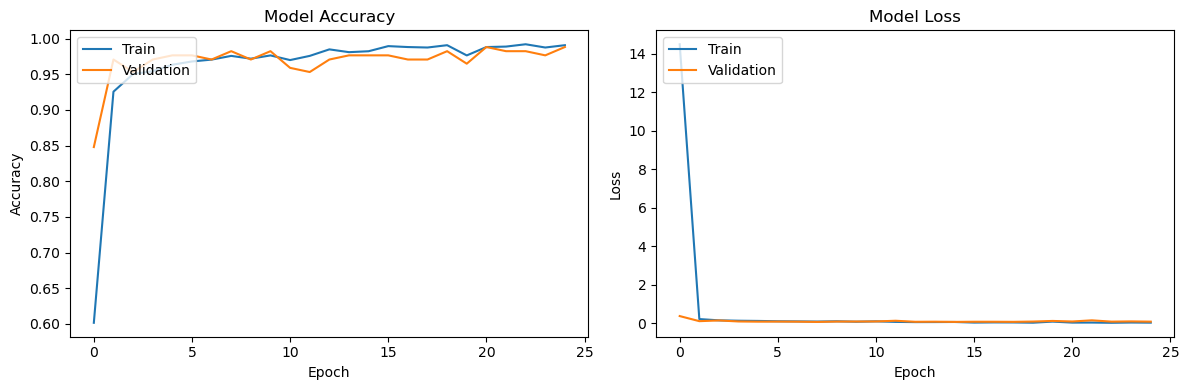

In [25]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyCNN_2.history['accuracy'])
ax1.plot(historyCNN_2.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyCNN_2.history['loss'])
ax2.plot(historyCNN_2.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [30]:
# Load model terbaik dari checkpoint
best_model_cnn_2 = tf.keras.models.load_model('best_model_cnn_2.h5')

# Evaluasi akurasi dan loss pada set validation
loss, accuracy = best_model_cnn_2.evaluate(x_validation, y_validation)
print(f'Validation Accuracy: {accuracy * 100:.3f}%')
print(f'Validation Loss: {loss:.4f}')

# Generate classification report
y_pred = best_model_cnn_2.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_best_cnn_2 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN 2:')
print(class_report_best_cnn_2)

6/6 [==============================] - 1s 92ms/step - loss: 0.0880 - accuracy: 0.9883
Validation Accuracy: 98.830%
Validation Loss: 0.0880
6/6 [==============================] - 1s 88ms/step
Classification Report Model CNN 2:
              precision    recall  f1-score   support

      Opened       1.00      0.98      0.99        87
      Closed       0.98      1.00      0.99        84

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [28]:
# Evaluasi akurasi dan loss pada set validation
validation_loss, validation_accuracy = model_cnn_2.evaluate(x_validation, y_validation, verbose=1)
print(f'validation accuracy: {validation_accuracy*100:.3f}%')
print(f'validation loss: {validation_loss:.4f}')

# Memprediksi label pada set validation
y_pred = model_cnn_2.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_cnn_2 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN 2:')
print(class_report_cnn_2)

6/6 [==============================] - 1s 90ms/step - loss: 0.0671 - accuracy: 0.9766
validation accuracy: 97.661%
validation loss: 0.0671
6/6 [==============================] - 1s 97ms/step
Classification Report Model CNN 2:
              precision    recall  f1-score   support

      Opened       0.98      0.98      0.98        87
      Closed       0.98      0.98      0.98        84

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



Confusion Matrix:
[[85  2]
 [ 0 84]]


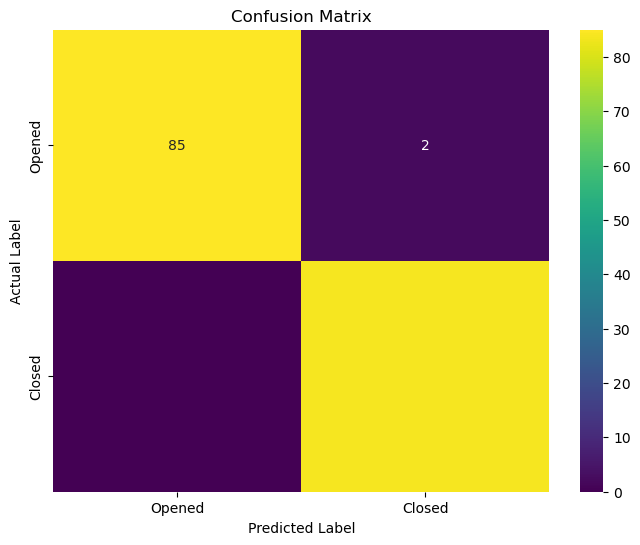

In [31]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model CNN 2**

melakukan predict data dengan gambar baru pada folder Test Set untuk melihat prediksi pada data yang belum pernah dikenali model

1/1 [==============================] - 0s 57ms/step


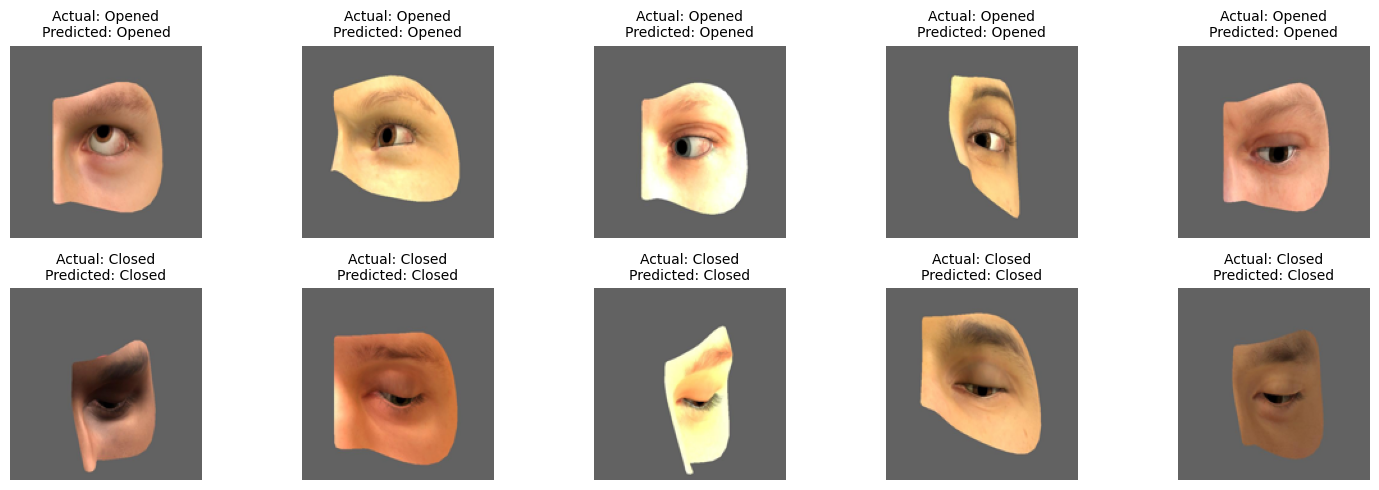

In [42]:
# Load model .h5
model_predict_2 = tf.keras.models.load_model('best_model_cnn_2.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

# Membuat list categories
categories = ['Opened', 'Closed']

# Inisialisasi lists untuk store images (X) dan label yang ada (Y)
X_samples = []
Y_samples = []

# preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array

for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    # Shuffle image untuk memastikan gambar dirandom
    random.shuffle(image_files)
    #Mengambil 5 image setelah di shuffle
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

# Convert lists ke numpy
X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_2.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model CNN 3 [Regularization Yes - Batch Size 64]**

Model ketiga adalah model CNN tanpa transfer learning dengan 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN dengan memakai regularization dan batch size = 64

In [32]:
# Define jumlah kelas
num_classes = 2

# Input layer
inputs = Input(shape=(150, 150, 3))

# Layer 1
x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 4
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 5
x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten layer untuk convert the 3D feature maps menjadi 1D
x = Flatten()(x)

# Dense layer dengan 1024 neurons dan ReLU activation
x = Dense(1024, kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
x = Dense(num_classes, kernel_regularizer=regularizers.l2(0.01))(x)
outputs = Activation('softmax')(x)

# Membuat model_cnn_3
model_cnn_3 = Model(inputs=inputs, outputs=outputs)

# Melakukan compile dengan categorical crossentropy loss, Adam optimizer, & accuracy metrik
model_cnn_3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Membuat checkpoint callback uuntuk menyimpan best model_cnn_3 based berdasarkan validation accuracy
checkpointCNN_3 = ModelCheckpoint('best_model_cnn_3.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_cnn_3
batch_size = 64 
historyCNN_3 = model_cnn_3.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        verbose=1, 
                        epochs=30, 
                        validation_data=(x_validation, y_validation), 
                        shuffle=False,
                        callbacks=[checkpointCNN_3, custom_early_stopping])

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 23.9146 - accuracy: 0.5336
Epoch 1: val_accuracy improved from -inf to 0.53216, saving model to best_model_cnn_3.h5
24/24 [==============================] - 27s 1s/step - loss: 23.9146 - accuracy: 0.5336 - val_loss: 12.0872 - val_accuracy: 0.5322
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 10.8373 - accuracy: 0.7489
Epoch 2: val_accuracy improved from 0.53216 to 0.88304, saving model to best_model_cnn_3.h5
24/24 [==============================] - 25s 1s/step - loss: 10.8373 - accuracy: 0.7489 - val_loss: 9.5432 - val_accuracy: 0.8830
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 8.7639 - accuracy: 0.9198
Epoch 3: val_accuracy improved from 0.88304 to 0.95322, saving model to best_model_cnn_3.h5
24/24 [==============================] - 23s 978ms/step - loss: 8.7639 - accuracy: 0.9198 - val_loss: 7.9785 - val_accuracy: 0.9532
Epoch 4/30
24/24 [==============================] 

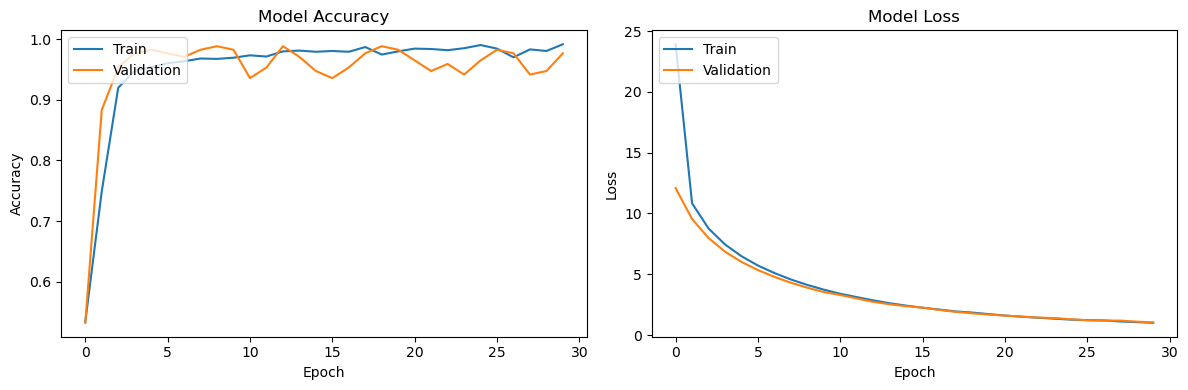

In [33]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyCNN_3.history['accuracy'])
ax1.plot(historyCNN_3.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyCNN_3.history['loss'])
ax2.plot(historyCNN_3.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
# Load model terbaik dari checkpoint
best_model_cnn_3 = tf.keras.models.load_model('best_model_cnn_3.h5')

# Evaluasi akurasi dan loss pada set validation
loss, accuracy = best_model_cnn_3.evaluate(x_validation, y_validation)
print(f'Validation Accuracy: {accuracy * 100:.3f}%')
print(f'Validation Loss: {loss:.4f}')

# Generate classification report
y_pred = best_model_cnn_3.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_best_cnn_3 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN 3:')
print(class_report_best_cnn_3)

6/6 [==============================] - 1s 83ms/step - loss: 3.8918 - accuracy: 0.9883
Validation Accuracy: 98.830%
Validation Loss: 3.8918
6/6 [==============================] - 1s 81ms/step
Classification Report Model CNN 3:
              precision    recall  f1-score   support

      Opened       1.00      0.98      0.99        87
      Closed       0.98      1.00      0.99        84

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [35]:
# Evaluasi akurasi dan loss pada set validation
validation_loss, validation_accuracy = model_cnn_3.evaluate(x_validation, y_validation, verbose=1)
print(f'validation accuracy: {validation_accuracy*100:.3f}%')
print(f'validation loss: {validation_loss:.4f}')

# Memprediksi label pada set validation
y_pred = model_cnn_3.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_cnn_3 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN 3:')
print(class_report_cnn_3)

6/6 [==============================] - 1s 85ms/step - loss: 1.0324 - accuracy: 0.9766
validation accuracy: 97.661%
validation loss: 1.0324
6/6 [==============================] - 1s 84ms/step
Classification Report Model CNN 3:
              precision    recall  f1-score   support

      Opened       0.98      0.98      0.98        87
      Closed       0.98      0.98      0.98        84

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



Confusion Matrix:
[[85  2]
 [ 2 82]]


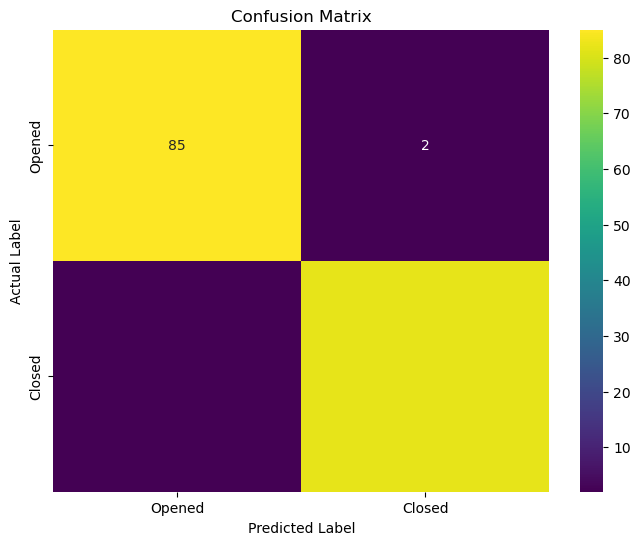

In [36]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model CNN 3**

melakukan predict data dengan gambar baru pada folder Test Set untuk melihat prediksi pada data yang belum pernah dikenali model

1/1 [==============================] - 0s 40ms/step


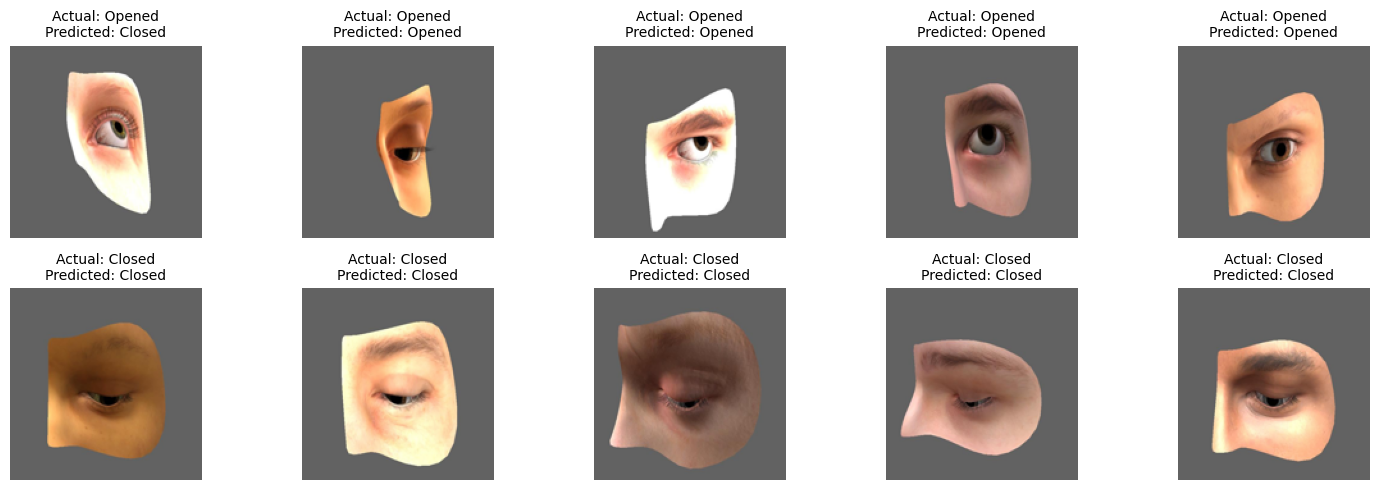

In [43]:
# Load model .h5
model_predict_3 = tf.keras.models.load_model('best_model_cnn_3.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

# Membuat list categories
categories = ['Opened', 'Closed']

# Inisialisasi lists untuk store images (X) dan label yang ada (Y)
X_samples = []
Y_samples = []

# preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array

for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    # Shuffle image untuk memastikan gambar dirandom
    random.shuffle(image_files)
    #Mengambil 5 image setelah di shuffle
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

# Convert lists ke numpy
X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_3.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model CNN 4 [Regularization No - Batch Size 64]**

Model ketiga adalah model CNN tanpa transfer learning dengan 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN tanpa regularization dan batch size = 64

In [37]:
# Define jumlah kelas
num_classes = 2

# Input layer
inputs = Input(shape=(150, 150, 3))

# Layer 1
x = Conv2D(32, (3, 3), padding='same')(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 4
x = Conv2D(128, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 5
x = Conv2D(512, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten layer untuk convert the 3D feature maps menjadi 1D
x = Flatten()(x)

# Dense layer dengan 1024 neurons dan ReLU activation
x = Dense(1024)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
x = Dense(num_classes)(x)
outputs = Activation('softmax')(x)

# Membuat model_cnn_4
model_cnn_4 = Model(inputs=inputs, outputs=outputs)

# Melakukan compile dengan categorical crossentropy loss, Adam optimizer, & accuracy metrik
model_cnn_4.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Membuat checkpoint callback uuntuk menyimpan best model_cnn_4 based berdasarkan validation accuracy
checkpointCNN_4 = ModelCheckpoint('best_model_cnn_4.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_cnn_4
batch_size = 64 
historyCNN_4 = model_cnn_4.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        verbose=1, 
                        epochs=30, 
                        validation_data=(x_validation, y_validation), 
                        shuffle=False,
                        callbacks=[checkpointCNN_4, custom_early_stopping])

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 4.5790 - accuracy: 0.5806
Epoch 1: val_accuracy improved from -inf to 0.73684, saving model to best_model_cnn_4.h5
24/24 [==============================] - 24s 951ms/step - loss: 4.5790 - accuracy: 0.5806 - val_loss: 0.5947 - val_accuracy: 0.7368
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.8539
Epoch 2: val_accuracy improved from 0.73684 to 0.94152, saving model to best_model_cnn_4.h5
24/24 [==============================] - 25s 1s/step - loss: 0.3431 - accuracy: 0.8539 - val_loss: 0.1731 - val_accuracy: 0.9415
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9335
Epoch 3: val_accuracy improved from 0.94152 to 0.97661, saving model to best_model_cnn_4.h5
24/24 [==============================] - 24s 1s/step - loss: 0.1960 - accuracy: 0.9335 - val_loss: 0.1188 - val_accuracy: 0.9766
Epoch 4/30
24/24 [==============================] - ETA

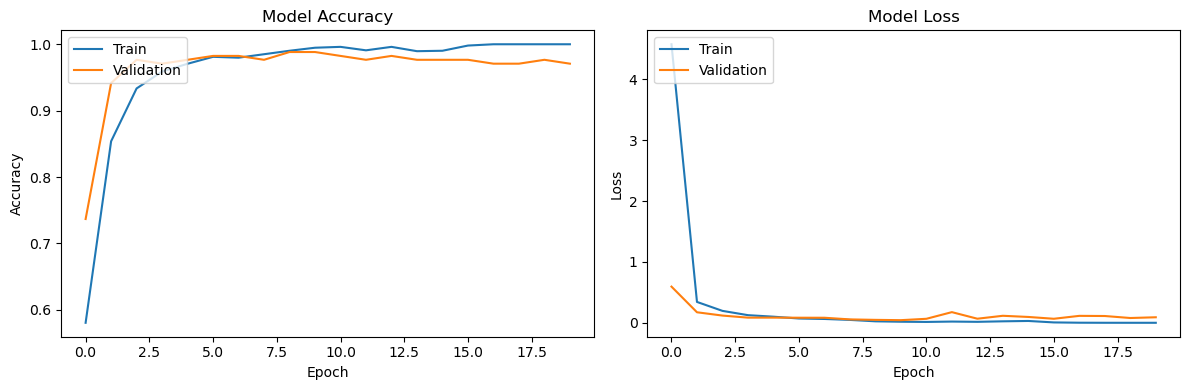

In [38]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyCNN_4.history['accuracy'])
ax1.plot(historyCNN_4.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyCNN_4.history['loss'])
ax2.plot(historyCNN_4.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [39]:
# Load model terbaik dari checkpoint
best_model_cnn_4 = tf.keras.models.load_model('best_model_cnn_4.h5')

# Evaluasi akurasi dan loss pada set validation
loss, accuracy = best_model_cnn_4.evaluate(x_validation, y_validation)
print(f'Validation Accuracy: {accuracy * 100:.3f}%')
print(f'Validation Loss: {loss:.4f}')

# Generate classification report
y_pred = best_model_cnn_4.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_best_cnn_4 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN 4:')
print(class_report_best_cnn_4)

6/6 [==============================] - 1s 79ms/step - loss: 0.0483 - accuracy: 0.9883
Validation Accuracy: 98.830%
Validation Loss: 0.0483
6/6 [==============================] - 1s 76ms/step
Classification Report Model CNN 4:
              precision    recall  f1-score   support

      Opened       0.99      0.99      0.99        87
      Closed       0.99      0.99      0.99        84

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [40]:
# Evaluasi akurasi dan loss pada set validation
validation_loss, validation_accuracy = model_cnn_4.evaluate(x_validation, y_validation, verbose=1)
print(f'validation accuracy: {validation_accuracy*100:.3f}%')
print(f'validation loss: {validation_loss:.4f}')

# Memprediksi label pada set validation
y_pred = model_cnn_4.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_cnn_4 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN 4:')
print(class_report_cnn_4)

6/6 [==============================] - 0s 78ms/step - loss: 0.0434 - accuracy: 0.9883
validation accuracy: 98.830%
validation loss: 0.0434
6/6 [==============================] - 3s 421ms/step
Classification Report Model CNN 4:
              precision    recall  f1-score   support

      Opened       1.00      0.98      0.99        87
      Closed       0.98      1.00      0.99        84

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



Confusion Matrix:
[[85  2]
 [ 0 84]]


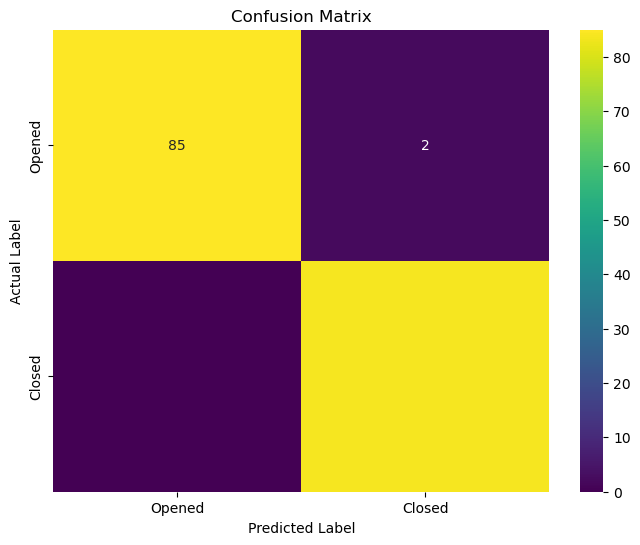

In [41]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model CNN 4**

melakukan predict data dengan gambar baru pada folder Test Set untuk melihat prediksi pada data yang belum pernah dikenali model

1/1 [==============================] - 0s 41ms/step


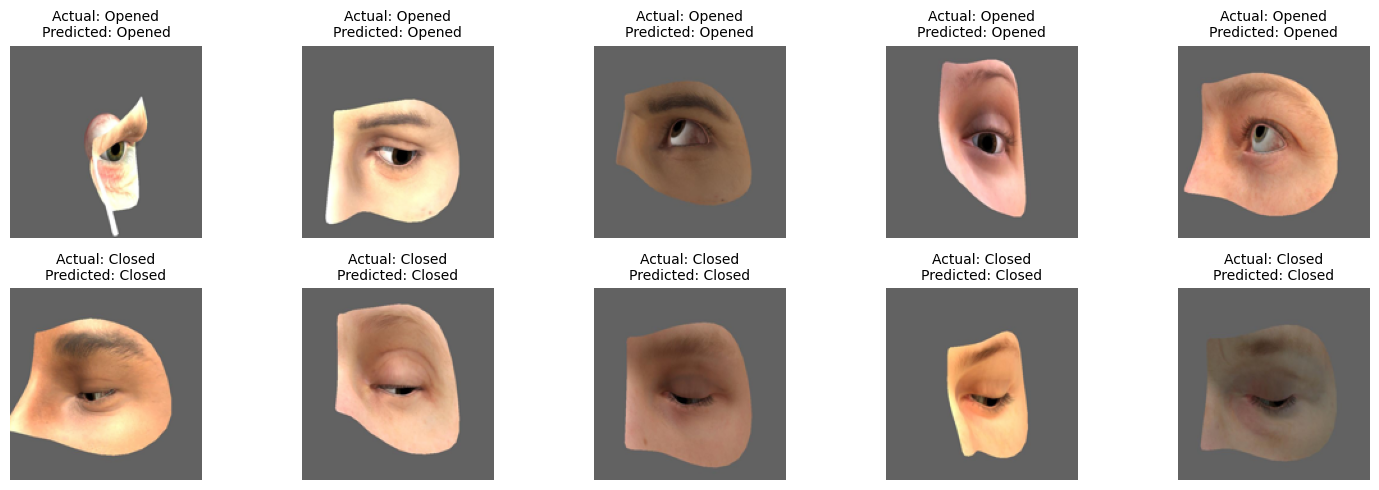

In [44]:
# Load model .h5
model_predict_4 = tf.keras.models.load_model('best_model_cnn_4.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

# Membuat list categories
categories = ['Opened', 'Closed']

# Inisialisasi lists untuk store images (X) dan label yang ada (Y)
X_samples = []
Y_samples = []

# preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array

for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    # Shuffle image untuk memastikan gambar dirandom
    random.shuffle(image_files)
    #Mengambil 5 image setelah di shuffle
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

# Convert lists ke numpy
X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_4.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model Evaluation**

In [50]:
import time

# List model file paths
model_paths = [
    'best_model_cnn_1.h5',
    'best_model_cnn_2.h5',
    'best_model_cnn_3.h5',
    'best_model_cnn_4.h5'
]

# Placeholder untuk nama kategori
categories = ['Opened', 'Closed']  # Sesuaikan dengan kategori Anda

# Loop untuk mengevaluasi setiap model
for model_path in model_paths:
    print(f"\n# Evaluasi model: {model_path}")
    
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Start timer untuk runtime
    start_time = time.time()
    
    # Evaluasi model pada validation set
    validation_loss, validation_accuracy = model.evaluate(x_validation, y_validation, verbose=1)
    
    # Prediksi untuk classification report
    y_pred = model.predict(x_validation, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_validation, axis=1)
    
    # Hitung runtime
    runtime = time.time() - start_time
    
    # Classification report
    class_report = classification_report(y_true, y_pred_classes, target_names=categories)

    # confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
    # Tampilkan hasil evaluasi
    print(f"\nRuntime: {runtime:.1f} s")
    print(f"Validation Accuracy: {validation_accuracy * 100:.3f}%")
    print(f"Validation Loss: {validation_loss:.4f}")
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)



# Evaluasi model: best_model_cnn_1.h5
6/6 [==============================] - 1s 124ms/step

Runtime: 2.1 s
Validation Accuracy: 98.830%
Validation Loss: 1.0084
Classification Report:
              precision    recall  f1-score   support

      Opened       1.00      0.98      0.99        87
      Closed       0.98      1.00      0.99        84

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Confusion Matrix:
[[85  2]
 [ 0 84]]

# Evaluasi model: best_model_cnn_2.h5
6/6 [==============================] - 1s 128ms/step

Runtime: 2.1 s
Validation Accuracy: 98.830%
Validation Loss: 0.0880
Classification Report:
              precision    recall  f1-score   support

      Opened       1.00      0.98      0.99        87
      Closed       0.98      1.00      0.99        84

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       

## **Kesimpulan**

Pada project Computer Vision ini menggunakan algoritma Convolutional Neural Network dengan membandingkan jika sebuah Model CNN diberi atau tidak diberikan parameter regularizer dan perbedaan batch size. Keempat model CNN ini dapat dibandingkan untuk melihat model mana yang menghasilkan akurasi paling baik, runtime terendah, dan loss terendah. Berikut adalah hasil perbadingan akurasi dari keempat model:

1. Model CNN 1 dengan Regularizers dan batch Size 32 ===========> `Loss: 1.0084 ; Validation Acc: 98.8% ; F1-Score: 99% (2.1 s)`
2. Model CNN 1 tanpa Regularizers dan batch Size 32 ============> `Loss: 0.0880 ; Validation Acc: 98.8% ; F1-Score: 99% (2.1 s)`
3. Model CNN 1 dengan Regularizers dan batch Size 64 ===========> `Loss: 3.8918 ; Validation Acc: 98.8% ; F1-Score: 99% (2.1 s`)
4. **Model CNN 1 tanpa Regularizers dan batch Size 64 ==========> `Loss: 0.0483 ; Validation Acc: 98.8% ; F1-Score: 99% (1.6 s)`**

Seluruh model tidak memiliki overvitting maupun underfitting yang ditunjukan dari plot visualisasi loss dan akurasi data training dan validation. Oleh karena itu Model **CNN 1 tanpa Regularizers dan batch Size 64** menjadi model paling baik untuk dataset model kantuk ini.

Untuk pemodelan lebih lanjut, data pada folder TrainingSet dapat ditambahkan data dari ImprovementSet untuk memperbanyak data dan bisa menambah akurasi yang dihasilkan nantinya.